In [1]:
%matplotlib inline
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from sklearn.externals import joblib
import os
import glob
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from skimage.io import imread
import cv2

In [2]:
test_image = cv2.imread('../data/images/test-10.pgm', cv2.IMREAD_GRAYSCALE)

In [3]:
test_image.shape

(150, 200)

In [4]:
test_image.dtype

dtype('uint8')

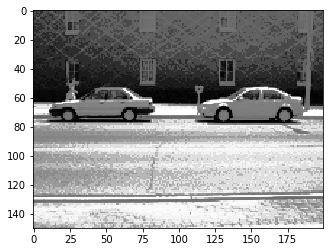

In [5]:
plt.imshow(test_image, cmap='gray')

In [6]:
def sliding_window(image, window_size, step_size):
    for row in xrange(0, image.shape[0], step_size[0]):
        for col in xrange(0, image.shape[1], step_size[1]):
            yield (row, col, image[row:row + window_size[0], col:col + window_size[1]])

In [7]:
window_size = (40, 100) # 滑窗大小和原训练图像大小相同
step_size = (10, 10)

In [8]:
model_path = '../data/models'
clf = joblib.load(os.path.join(model_path, 'svm.model'))

In [9]:
scale = 0
detections = []
downscale=1.25
for test_image_pyramid in pyramid_gaussian(test_image, downscale=downscale):
    if test_image_pyramid.shape[0] < window_size[0] or test_image_pyramid.shape[1] < window_size[1]:
        break
    for (row, col, sliding_image) in sliding_window(test_image_pyramid, window_size, step_size):
        if sliding_image.shape != window_size:
            continue
        sliding_image_hog = hog(sliding_image)
        sliding_image_hog = sliding_image_hog.reshape(1, -1)
    #     print('sliding_image_hog.shape:', sliding_image_hog.shape)
        pred = clf.predict(sliding_image_hog)
        if pred==1:
#             print('pred:', pred)
            pred_prob = clf.decision_function(sliding_image_hog)
#             print('pred_prob:', pred_prob)
#             print('scale:', scale)
            (window_height, window_width) = window_size
            # 返回x，y，pred_prob，width，height
            detections.append((int(col*downscale**scale), int(row*downscale**scale), pred_prob, int(window_width*downscale**scale), int(window_height*downscale**scale)))
    scale+=1

/Library/Python/2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


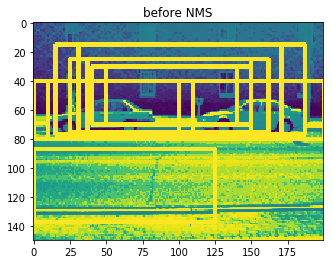

In [10]:
test_image_detect = test_image.copy()
for detection in detections:
    col = detection[0]
    row = detection[1]
    width = detection[3]
    height = detection[4]
    cv2.rectangle(test_image_detect, pt1=(col, row), pt2=(col+width, row+height), color=(255, 0, 0), thickness=2)
plt.title('before NMS')
plt.imshow(test_image_detect)

In [11]:
def overlapping_area(detection_1, detection_2):
    '''
    计算两个检测区域覆盖大小，detection：(x，y，pred_prob，width，height)
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0] # x1 top left
    x2_tl = detection_2[0] # x2 top left
    x1_br = detection_1[0] + detection_1[3] # x1 bottom right
    x2_br = detection_2[0] + detection_2[3] # x2 bottom right
    y1_tl = detection_1[1] # y1 top left
    y2_tl = detection_2[1] # y2 top left
    y1_br = detection_1[1] + detection_1[4] # y1 bottom right
    y2_br = detection_2[1] + detection_2[4] # y2 bottom right
    # Calculate the overlapping Area
    # 计算重叠区域
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    # 计算重叠区域占比
    return overlap_area / float(total_area)

In [12]:
def nms(detections, threshold=.5):
    '''
    非极大值抑制减少重叠区域，detection：(x，y，pred_prob，width，height)
    '''
    if len(detections) == 0:
        return []
    # Sort the detections based on confidence score
    # 根据预测值大小排序预测结果
    detections = sorted(detections, key=lambda detections: detections[2], reverse=True)
    # Unique detections will be appended to this list
    # 非极大值抑制后的检测区域
    new_detections=[]
    # Append the first detection
    # 默认第一个区域置信度最高是正确检测区域
    new_detections.append(detections[0])
    # Remove the detection from the original list
    # 去除以检测为正确的区域
    del detections[0]
    # For each detection, calculate the overlapping area
    # and if area of overlap is less than the threshold set
    # for the detections in `new_detections`, append the 
    # detection to `new_detections`.
    # In either case, remove the detection from `detections` list.
    for index, detection in enumerate(detections):
        overlapping_small = True
        for new_detection in new_detections:
            # 重叠区域过大，则删除该区域，同时结束检测，过小则继续检测
            if overlapping_area(detection, new_detection) > threshold:
                overlapping_small = False
                del detections[index]
                break
        if overlapping_small:
            # 整个循环中重叠区域都小那么增加
            new_detections.append(detection)
            del detections[index]
    return new_detections

In [13]:
threshold = 0.2
detections_nms = nms(detections, threshold)

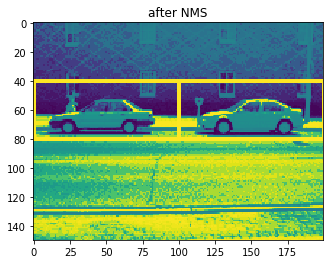

In [14]:
test_image_detect = test_image.copy()
for detection in detections_nms:
    col = detection[0]
    row = detection[1]
    width = detection[3]
    height = detection[4]
    cv2.rectangle(test_image_detect, pt1=(col, row), pt2=(col+width, row+height), color=(255, 0, 0), thickness=2)
plt.title('after NMS')
plt.imshow(test_image_detect)